### Streaming with Responses

In [ ]:
from dotenv import load_dotenv 
load_dotenv()

import os

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

#### Implementing simple Chatbot using LangGraph


In [ ]:
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated

In [ ]:
class State(BaseModel):
    messages: Annotated[list, add_messages]

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a788c5aef0', 'id': 'chatcmpl-CXpfTu5mAwxRTxttZXyX5zKwOZilG', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--d0633a75-f231-45ad-a544-0c98aa46210e-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
from langchain_groq import ChatGroq
llm_groq = ChatGroq(model="openai/gpt-oss-20b")
llm_groq.invoke("Hey I am Krish and I like playing cricket")

AIMessage(content='Hey Krish! 👋 Cricket’s a blast—do you play any particular role (batsman, bowler, all‑rounder)? Or maybe you’re a fan of a specific team?', additional_kwargs={'reasoning_content': 'The user says: "Hey I am Krish and I like playing cricket". It\'s a greeting. We should respond friendly, maybe ask about cricket. We should keep it short.'}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 81, 'total_tokens': 168, 'completion_time': 0.089716128, 'prompt_time': 0.004487224, 'queue_time': 0.048101796, 'total_time': 0.094203352}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_80501ff3a1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--b3f55125-5ed5-445f-a41d-632acbae7122-0', usage_metadata={'input_tokens': 81, 'output_tokens': 87, 'total_tokens': 168})

In [ ]:
# Creating nodes
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def chatbot(state: State):
    return {"messages": [llm_groq.invoke(state.messages)]}

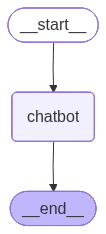

In [ ]:
# build the graph
builder = StateGraph(State)

# add nodes
builder.add_node("chatbot", chatbot)

# add edges
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile(checkpointer=memory)


# display the graph
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
# Invokation

# create a thread
config = {"configurable": {"thread_id": 1}}

graph.invoke({"messages": ["Hi, My name is krish and I like cricket"]}, config)

{'messages': [HumanMessage(content='Hi, My name is krish and I like cricket', additional_kwargs={}, response_metadata={}, id='44bf35bb-de2a-4b9a-a277-519720ebc67f'),
  AIMessage(content='Hey Krish! Great to meet a cricket fan—what’s your favorite team or player? 🏏', additional_kwargs={'reasoning_content': 'The user says "Hi, My name is krish and I like cricket". We need to respond. There\'s no policy violation. Just a friendly response.'}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 82, 'total_tokens': 145, 'completion_time': 0.063409256, 'prompt_time': 0.003958002, 'queue_time': 0.047383375, 'total_time': 0.067367258}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_80501ff3a1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--a2d301cf-d20b-43b9-90d5-cc81002b8ce9-0', usage_metadata={'input_tokens': 82, 'output_tokens': 63, 'total_tokens': 145})]}

## Streaming

Methods: .stream() and .astream()
* These methods are sync and async methos for streaming back results.

Additional parameters in streaming modes for graph state

* **values**: This streams the full state of the graph after each node is called.
* **updates**: this streams updates to the state of the graph after each node is called


#### Stream `updates`
returns the latest state of the graph

In [ ]:
# create a thread
config = {"configurable": {"thread_id": 1}}

for chunk in graph.stream({"messages": ["Hi, My name is krish and I like cricket"]}, config, stream_mode="updates"):
    print(chunk)

{'chatbot': {'messages': [AIMessage(content='Hey Krish! 👋 Cricket’s a massive sport—whether you’re into the IPL, international test matches, or just backyard games, I’d love to hear more. Who’s your favorite player or team? And what do you enjoy most about the game?', additional_kwargs={'reasoning_content': 'User repeats same message. We need to respond. They said name Krish, likes cricket. We can ask more about cricket preferences.'}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 125, 'total_tokens': 215, 'completion_time': 0.090351839, 'prompt_time': 0.006009602, 'queue_time': 0.046300664, 'total_time': 0.096361441}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_80501ff3a1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--164b7c34-9b90-47fc-a1be-6296f9ad3fb7-0', usage_metadata={'input_tokens': 125, 'output_tokens': 90, 'total_tokens': 215})]}}


In [ ]:
for chunk in graph.stream({"messages": ["I like cricket"]}, config, stream_mode="updates"):
    print(chunk)

{'chatbot': {'messages': [AIMessage(content='That’s awesome! Cricket has so many exciting moments. Do you follow a particular league (like the IPL, BBL, or international tests), or do you enjoy watching it in a more casual, backyard‑style setting? Also, who’s your favourite player or team?', additional_kwargs={'reasoning_content': 'User says "I like cricket". The conversation is simple. We can respond politely, ask follow-up. No policy issues.'}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 191, 'total_tokens': 281, 'completion_time': 0.09095993, 'prompt_time': 0.009233454, 'queue_time': 0.047696576, 'total_time': 0.100193384}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_80501ff3a1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--de8e3e15-72b5-4038-bc85-6cf4c68e89d0-0', usage_metadata={'input_tokens': 191, 'output_tokens': 90, 'total_tokens': 281})]}}


#### Stream `values`
returns the full state of the graph

In [ ]:
# create a thread
config = {"configurable": {"thread_id": 1}}

for chunk in graph.stream({"messages": ["Hi, My name is krish and I like cricket"]}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is krish and I like cricket', additional_kwargs={}, response_metadata={}, id='44bf35bb-de2a-4b9a-a277-519720ebc67f'), AIMessage(content='Hey Krish! Great to meet a cricket fan—what’s your favorite team or player? 🏏', additional_kwargs={'reasoning_content': 'The user says "Hi, My name is krish and I like cricket". We need to respond. There\'s no policy violation. Just a friendly response.'}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 82, 'total_tokens': 145, 'completion_time': 0.063409256, 'prompt_time': 0.003958002, 'queue_time': 0.047383375, 'total_time': 0.067367258}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_80501ff3a1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--a2d301cf-d20b-43b9-90d5-cc81002b8ce9-0', usage_metadata={'input_tokens': 82, 'output_tokens': 63, 'total_tokens': 145}), HumanMessage(content='Hi, My name 

In [ ]:
for chunk in graph.stream({"messages": ["I like sports"]}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is krish and I like cricket', additional_kwargs={}, response_metadata={}, id='44bf35bb-de2a-4b9a-a277-519720ebc67f'), AIMessage(content='Hey Krish! Great to meet a cricket fan—what’s your favorite team or player? 🏏', additional_kwargs={'reasoning_content': 'The user says "Hi, My name is krish and I like cricket". We need to respond. There\'s no policy violation. Just a friendly response.'}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 82, 'total_tokens': 145, 'completion_time': 0.063409256, 'prompt_time': 0.003958002, 'queue_time': 0.047383375, 'total_time': 0.067367258}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_80501ff3a1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--a2d301cf-d20b-43b9-90d5-cc81002b8ce9-0', usage_metadata={'input_tokens': 82, 'output_tokens': 63, 'total_tokens': 145}), HumanMessage(content='Hi, My name 

#### Streaming The Responses With `astream_events` Method

**Streaming tokens**
We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the **tokens** as they are generated.

We can do this using the .astream_events method, which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

- event: This is the type of event that is being emitted.
- name: This is the name of event.
- data: This is the data associated with the event.
- metadata: Containslanggraph_node, the node emitting the event.

In [ ]:
# create a thread
config = {"configurable": {"thread_id": 3}}

config = {"configurable": {"thread_id": "3"}}

# this streams the state of the graph when any event occured
async for event in graph.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Krish and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'afde0c96-1e4a-4ed4-9d2d-59128cb6840a', 'metadata': {'thread_id': '3'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': State(messages=[HumanMessage(content='Hi My name is Krish and I like to play cricket', additional_kwargs={}, response_metadata={}, id='c378ae86-d1f8-4394-8eb9-de68cb167e60')])}, 'name': 'chatbot', 'tags': ['graph:step:1'], 'run_id': '313ab347-66f5-4e75-ba4f-7e3c693b4a80', 'metadata': {'thread_id': '3', 'langgraph_step': 1, 'langgraph_node': 'chatbot', 'langgraph_triggers': ('branch:to:chatbot',), 'langgraph_path': ('__pregel_pull', 'chatbot'), 'langgraph_checkpoint_ns': 'chatbot:17ee3881-9773-5984-48e0-e2c015a73b8b'}, 'parent_ids': ['afde0c96-1e4a-4ed4-9d2d-59128cb6840a']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Krish and I like to play c